In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
import mahotas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\khushi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
image_dir = r'C:\Users\khushi\Desktop\FCV Project\data\HAM10000_images_part_1'
data = pd.read_csv(r'C:\Users\khushi\Desktop\FCV Project\data\HAM10000_metadata.csv')

In [3]:
data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
import random

def plot_random_samples(X_test, y_test, y_pred, image_paths_test, num_samples=10):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X_test)), num_samples)
    
    for i, idx in enumerate(indices):
        img_path = image_paths_test[idx]
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (224, 224))
        true_label = y_test[idx]
        pred_label = y_pred[idx]

        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [5]:
image_paths = []
labels = []

for index, row in data.iterrows():
    img_path = os.path.join(image_dir, f"{row['image_id']}.jpg")

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
    else:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
        else:
            image_paths.append(img_path)
            labels.append(row['dx'])

In [6]:
print(f"Total successfully loaded images: {len(image_paths)}")
print(f"Total images (including missing/failed): {len(data)}")

Total successfully loaded images: 10015
Total images (including missing/failed): 10015


In [7]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [8]:
def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    moments = cv2.moments(binary)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

In [9]:
def extract_haralick_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    texture = mahotas.features.texture.haralick(gray)
    return texture.mean(axis=0)

In [10]:
def augment_data(image):
    return cv2.flip(image, 1)

In [11]:
def load_and_extract_features(image_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))

    color_features = extract_color_histogram(img_resized)
    hu_moments = extract_hu_moments(img_resized)
    texture_features = extract_haralick_texture(img_resized)

    features = np.hstack([color_features, hu_moments, texture_features])

    augmented_img = augment_data(img_resized)
    color_features_augmented = extract_color_histogram(augmented_img)
    hu_moments_augmented = extract_hu_moments(augmented_img)
    texture_features_augmented = extract_haralick_texture(augmented_img)

    augmented_features = np.hstack([color_features_augmented, hu_moments_augmented, texture_features_augmented])

    return features, augmented_features

In [12]:
X = []
y = []

for img_path, label in zip(image_paths, labels):
    features, augmented_features = load_and_extract_features(img_path)
    X.append(features)
    X.append(augmented_features)
    y.append(label)
    y.append(label)

In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision tree model

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [57]:
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.928607089365951
Decision Tree Classification Report:
              precision    recall  f1-score   support

       akiec       0.88      0.88      0.88       129
         bcc       0.90      0.87      0.88       194
         bkl       0.85      0.88      0.87       401
          df       0.78      0.84      0.81        51
         mel       0.86      0.86      0.86       472
          nv       0.96      0.96      0.96      2708
        vasc       0.83      0.76      0.80        51

    accuracy                           0.93      4006
   macro avg       0.87      0.86      0.87      4006
weighted avg       0.93      0.93      0.93      4006



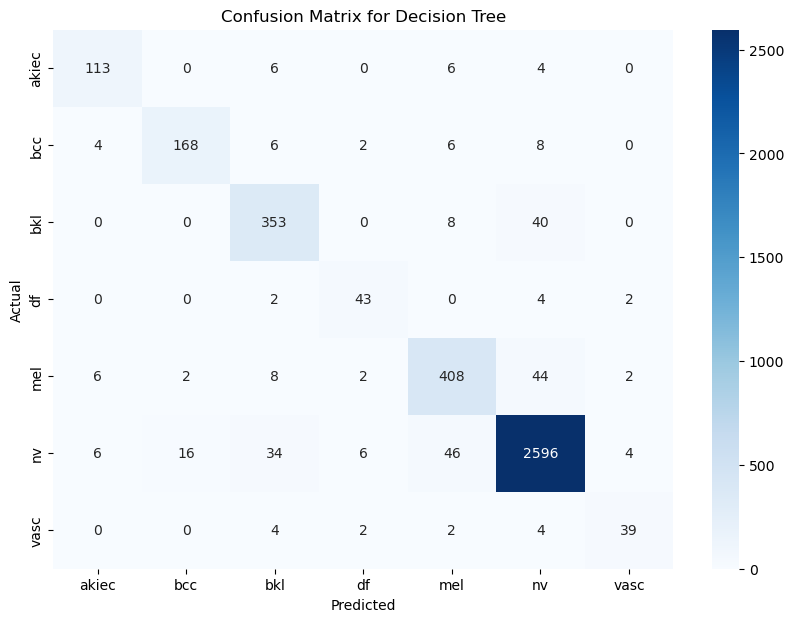

In [58]:
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

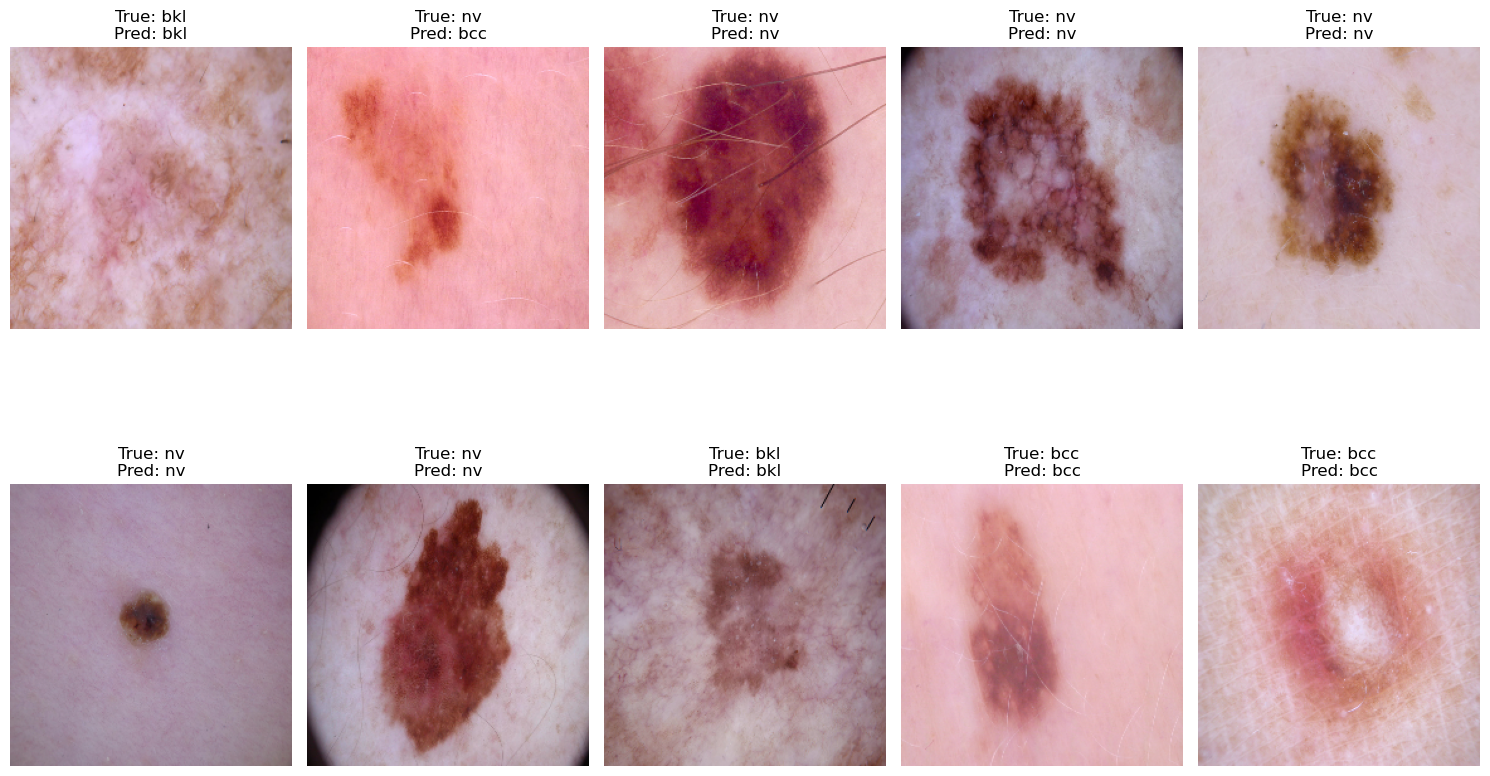

In [59]:
plot_random_samples(X_test, y_test, y_pred_dt, image_paths, num_samples=10)

## Random forest model

In [60]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [64]:
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9500748876684972
Random Forest Classification Report:
              precision    recall  f1-score   support

       akiec       0.98      0.84      0.91       129
         bcc       0.96      0.85      0.90       194
         bkl       0.93      0.89      0.91       401
          df       1.00      0.80      0.89        51
         mel       0.96      0.84      0.90       472
          nv       0.95      1.00      0.97      2708
        vasc       1.00      0.76      0.87        51

    accuracy                           0.95      4006
   macro avg       0.97      0.86      0.91      4006
weighted avg       0.95      0.95      0.95      4006



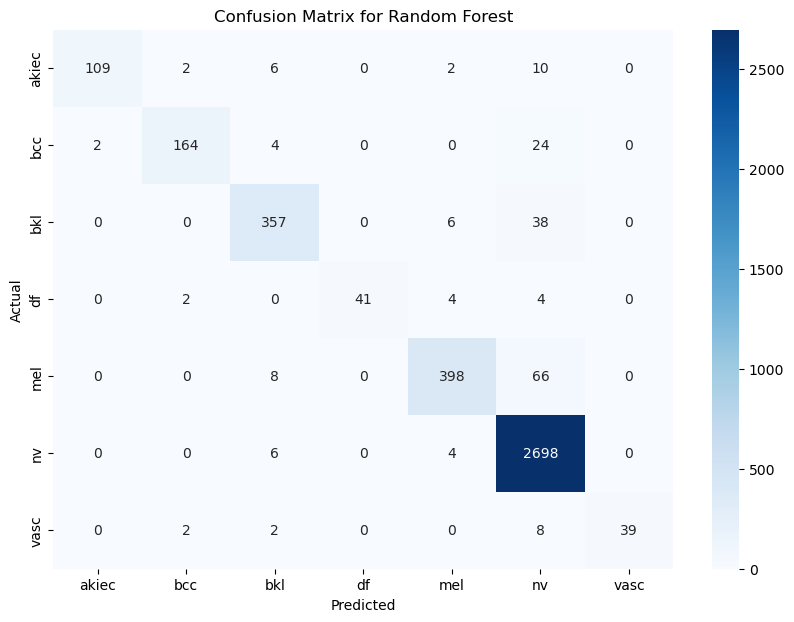

In [65]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Random Forest')
plt.show()

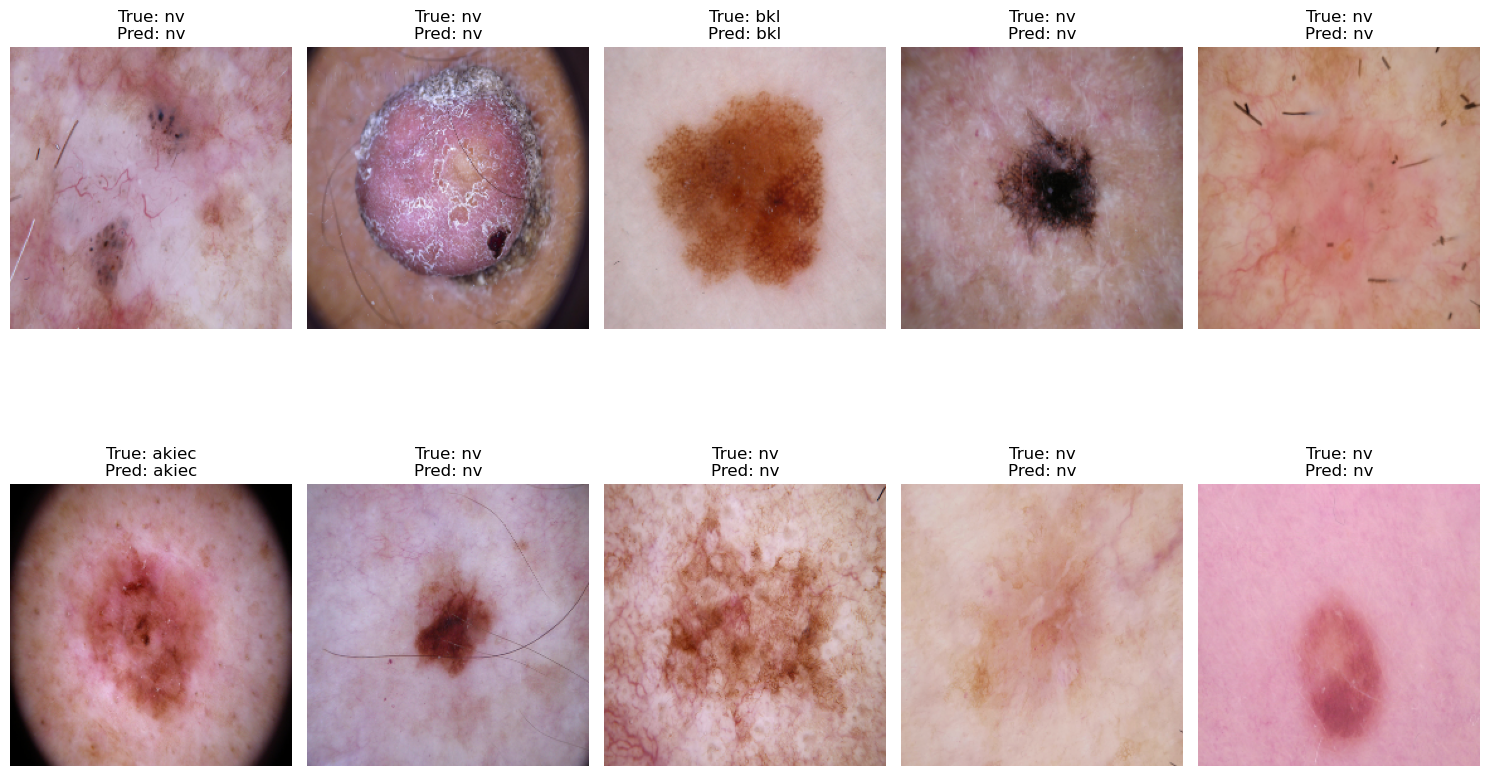

In [66]:
plot_random_samples(X_test, y_test, y_pred_rf, image_paths, num_samples=10)

## KNN model

In [67]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

In [68]:
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.6447828257613579
KNN Classification Report:
              precision    recall  f1-score   support

       akiec       0.15      0.17      0.16       129
         bcc       0.19      0.17      0.18       194
         bkl       0.25      0.23      0.24       401
          df       0.16      0.08      0.11        51
         mel       0.36      0.22      0.27       472
          nv       0.78      0.86      0.82      2708
        vasc       0.23      0.06      0.09        51

    accuracy                           0.64      4006
   macro avg       0.30      0.25      0.27      4006
weighted avg       0.61      0.64      0.62      4006



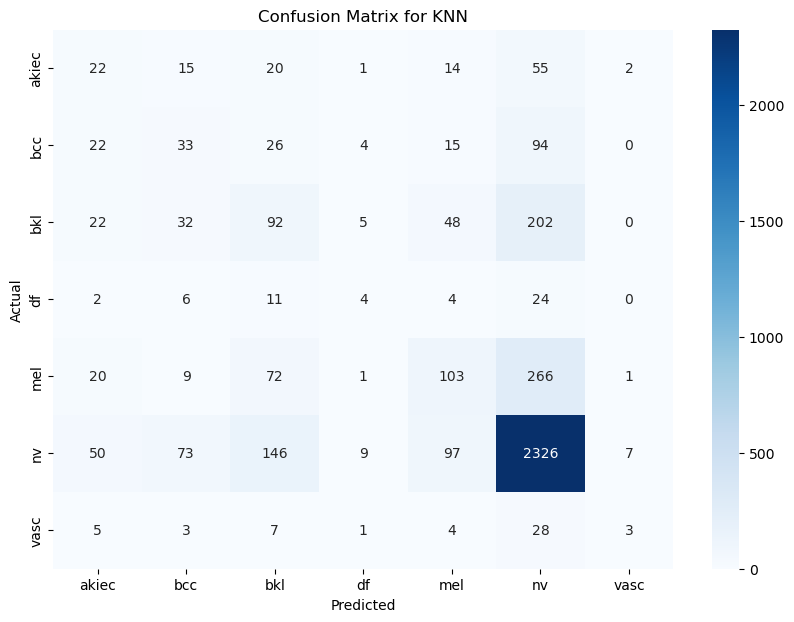

In [69]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for KNN')
plt.show()

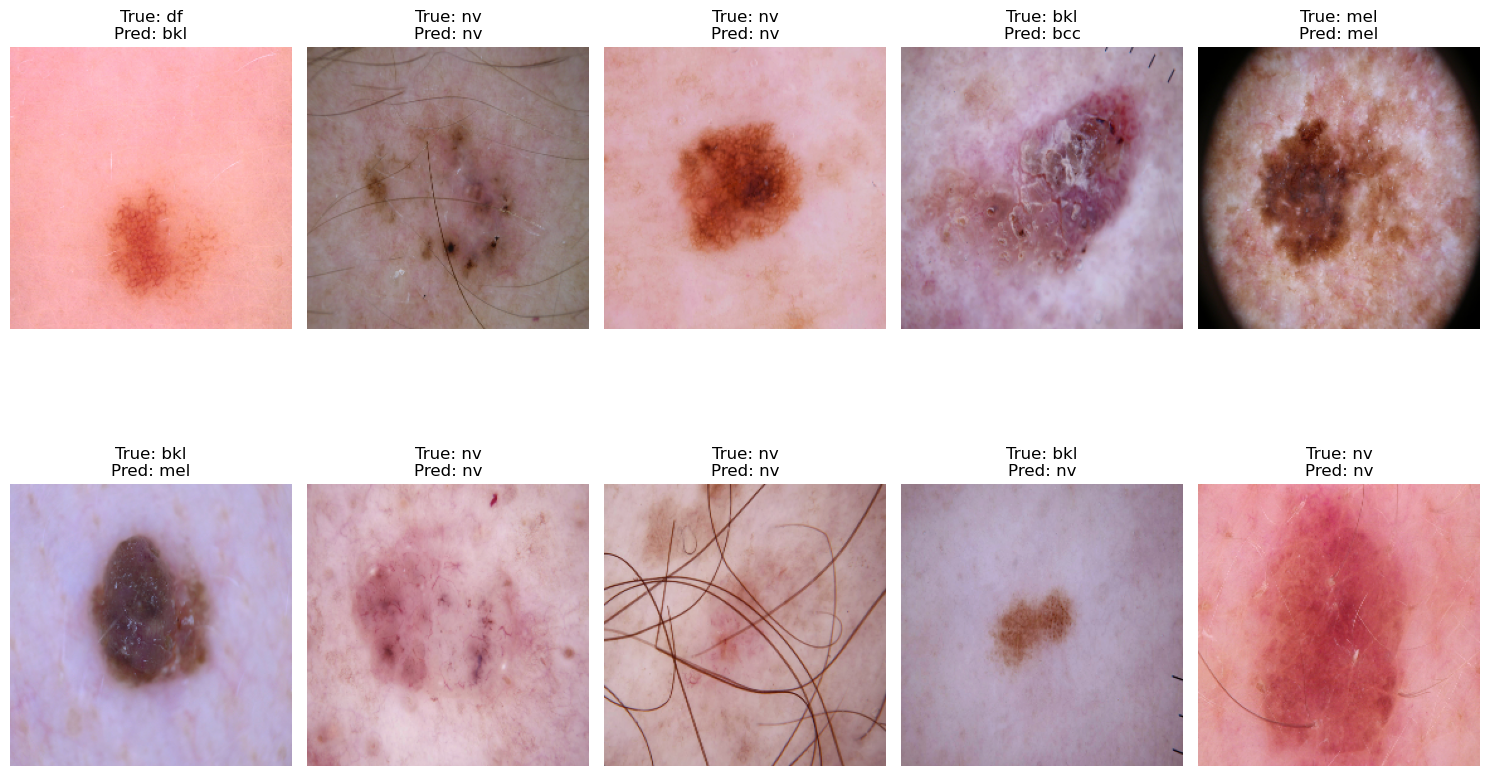

In [70]:
plot_random_samples(X_test, y_test, y_pred_knn, image_paths, num_samples=10)

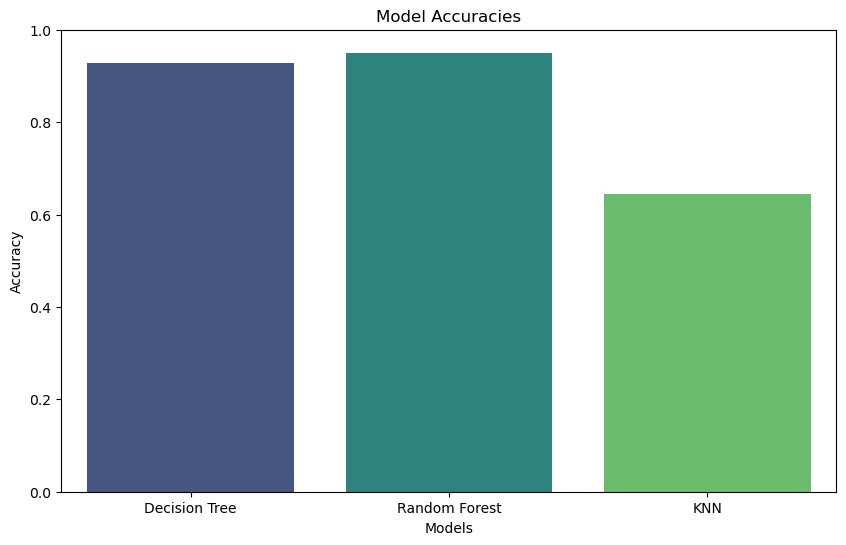

In [74]:
model_names = ['Decision Tree', 'Random Forest', 'KNN']
accuracies = [0.9286, 0.9501, 0.6448]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.show()

In [76]:
precision_scores = {
    'Decision Tree': [0.88, 0.90, 0.85, 0.78, 0.86, 0.96, 0.83],
    'Random Forest': [0.98, 0.96, 0.93, 1.00, 0.96, 0.95, 1.00],
    'KNN': [0.15, 0.19, 0.25, 0.16, 0.36, 0.78, 0.23]
}

recall_scores = {
    'Decision Tree': [0.88, 0.87, 0.88, 0.84, 0.86, 0.96, 0.76],
    'Random Forest': [0.84, 0.85, 0.89, 0.80, 0.84, 1.00, 0.76],
    'KNN': [0.17, 0.17, 0.23, 0.08, 0.22, 0.86, 0.06]
}

f1_scores = {
    'Decision Tree': [0.88, 0.88, 0.87, 0.81, 0.86, 0.96, 0.80],
    'Random Forest': [0.91, 0.90, 0.91, 0.89, 0.90, 0.97, 0.87],
    'KNN': [0.16, 0.18, 0.24, 0.11, 0.27, 0.82, 0.09]
}

class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
precision_df = pd.DataFrame(precision_scores, index=class_labels)
recall_df = pd.DataFrame(recall_scores, index=class_labels)
f1_df = pd.DataFrame(f1_scores, index=class_labels)

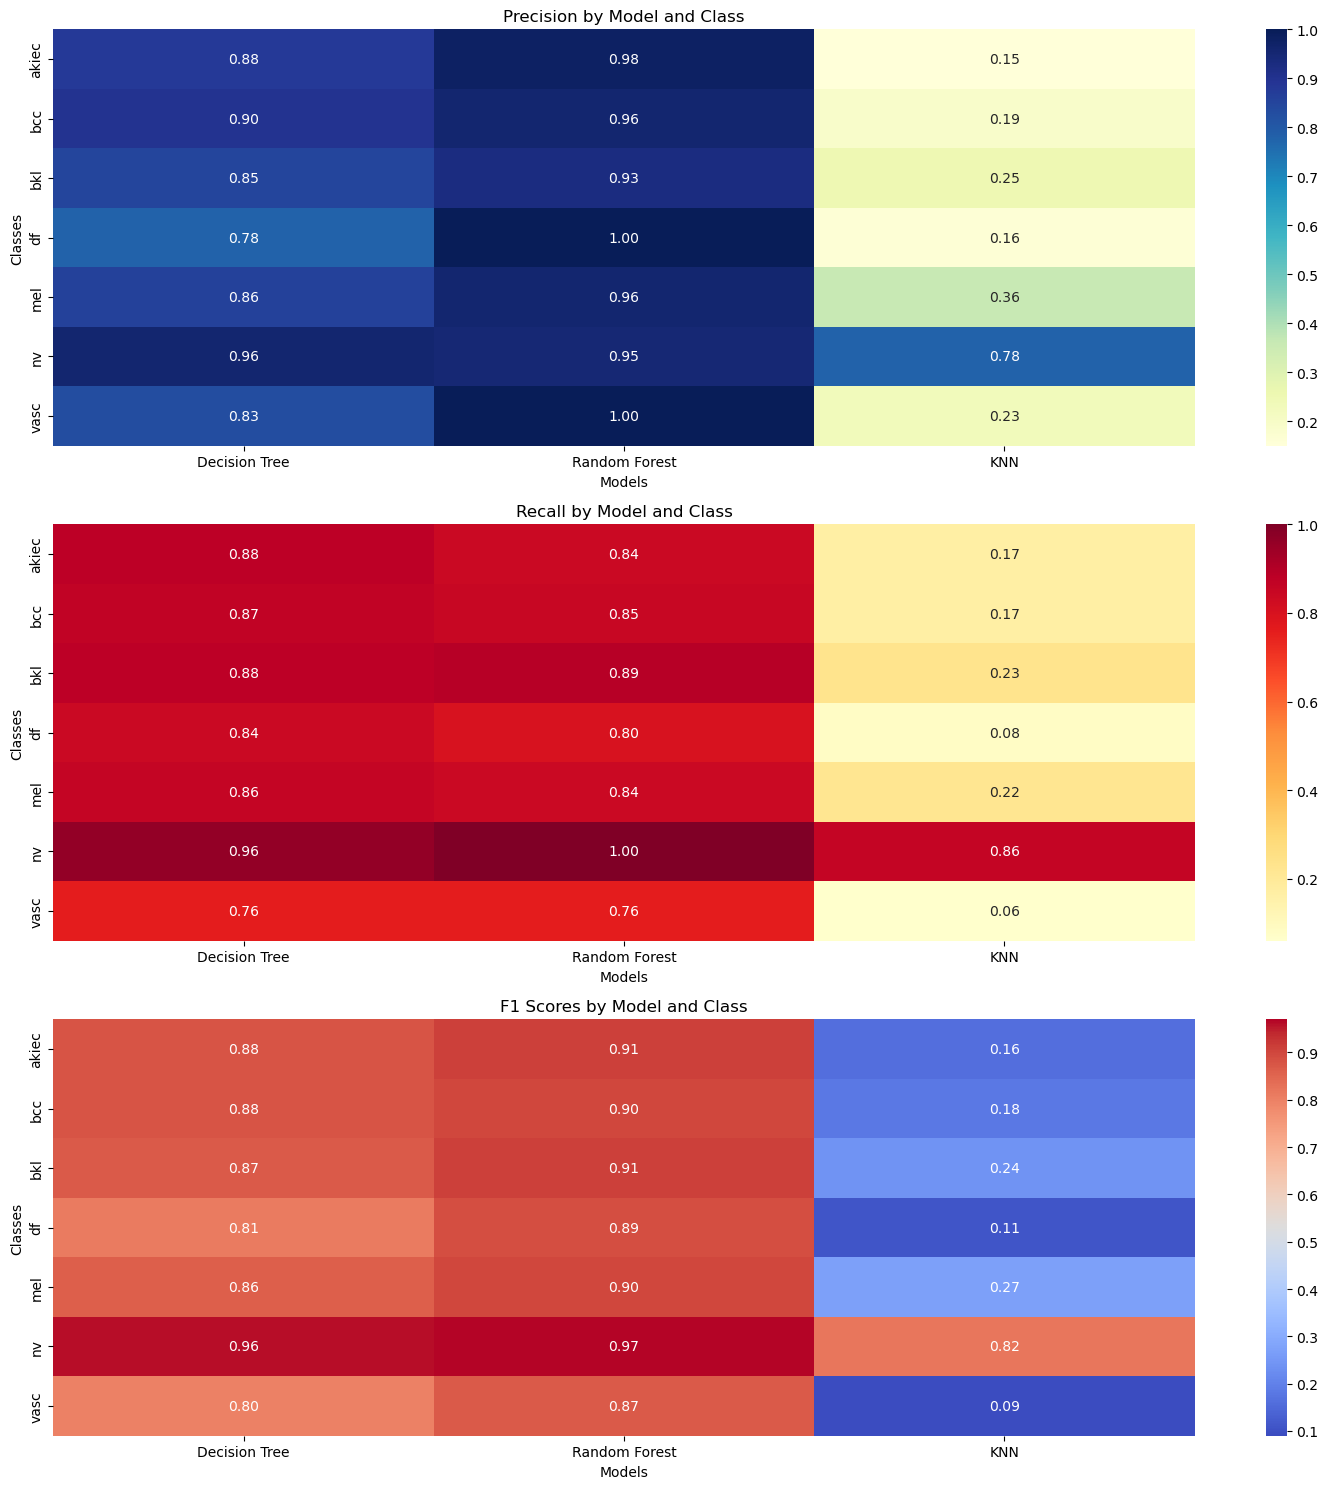

In [81]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

sns.heatmap(precision_df, annot=True, cmap='YlGnBu', cbar=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Precision by Model and Class")
axes[0].set_xlabel("Models")
axes[0].set_ylabel("Classes")

sns.heatmap(recall_df, annot=True, cmap='YlOrRd', cbar=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Recall by Model and Class")
axes[1].set_xlabel("Models")
axes[1].set_ylabel("Classes")

sns.heatmap(f1_df, annot=True, cmap='coolwarm', cbar=True, fmt=".2f", ax=axes[2])
axes[2].set_title("F1 Scores by Model and Class")
axes[2].set_xlabel("Models")
axes[2].set_ylabel("Classes")

plt.tight_layout()
plt.show()